In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Import and process the data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_data = torch.stack([mnist_train[i][0] for i in range(len(mnist_train))]).to(device)
test_data  = torch.stack([mnist_test[i][0] for i in range(len(mnist_test))]).to(device)

# Create the DL model

In [4]:
def createTheMNISTAE(n_enc,n_bottle):

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,n_enc)
      
      self.enc = nn.Linear(n_enc,n_bottle)

      self.lat = nn.Linear(n_bottle,n_enc)

      self.dec = nn.Linear(n_enc,784)

    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  net = aenet().to(device)
  
  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [5]:
def function2trainTheModel(n_enc, n_bottle):
    numepochs = 3
    net, lossfun, optimizer = createTheMNISTAE(n_enc, n_bottle)
    losses = []

    batchsize = 32
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True)

    for epochi in range(numepochs):
        batchlosses = []
        for batch in train_loader:
            batch = batch.to(device)
            yHat = net(batch)
            loss = lossfun(yHat, batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchlosses.append(loss.item())

        losses.append(np.mean(batchlosses))

    return losses, net

# Run the model and show the results!

In [6]:

N_encdec_units = np.linspace(10,500,12).astype(int)
N_bottle_units = np.linspace(5,100,8).astype(int)

exp_results = np.zeros((len(N_encdec_units),len(N_bottle_units)))

for ei,nenc in (enumerate(N_encdec_units)):
  for bi,nbot in (enumerate(N_bottle_units)):

    losses = function2trainTheModel(nenc,nbot)[0]
    exp_results[ei,bi] = np.mean(losses[-1])
    
    print(f"nenc: {nenc}, nbot: {nbot}, loss: {exp_results[ei,bi]}")

nenc: 10, nbot: 5, loss: 0.055597338104248044
nenc: 10, nbot: 18, loss: 0.05027754286726316
nenc: 10, nbot: 32, loss: 0.04617360964020093
nenc: 10, nbot: 45, loss: 0.04250417700409889
nenc: 10, nbot: 59, loss: 0.03662446889479955
nenc: 10, nbot: 72, loss: 0.04422777520020803
nenc: 10, nbot: 86, loss: 0.048930934874216715
nenc: 10, nbot: 100, loss: 0.05184525545835495
nenc: 54, nbot: 5, loss: 0.04459092624783516
nenc: 54, nbot: 18, loss: 0.021731423742572465
nenc: 54, nbot: 32, loss: 0.016725128872692584
nenc: 54, nbot: 45, loss: 0.015866841619213423
nenc: 54, nbot: 59, loss: 0.01606806619564692
nenc: 54, nbot: 72, loss: 0.015898391222457092
nenc: 54, nbot: 86, loss: 0.014713420950373014
nenc: 54, nbot: 100, loss: 0.014638956276575724
nenc: 99, nbot: 5, loss: 0.035342626250783604
nenc: 99, nbot: 18, loss: 0.0224686980843544
nenc: 99, nbot: 32, loss: 0.013664670725166798
nenc: 99, nbot: 45, loss: 0.0125611787656943
nenc: 99, nbot: 59, loss: 0.011063147167364756
nenc: 99, nbot: 72, loss: 

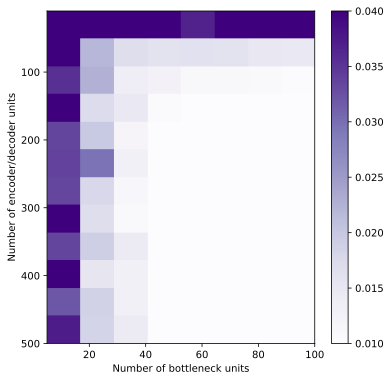

In [7]:
fig = plt.figure(figsize=(6,6))

plt.imshow(exp_results,aspect='auto',
           vmin=.01,vmax=.04, cmap='Purples',
           extent=[ N_bottle_units[0],N_bottle_units[-1],N_encdec_units[-1],N_encdec_units[0], ])
           

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()
plt.show()

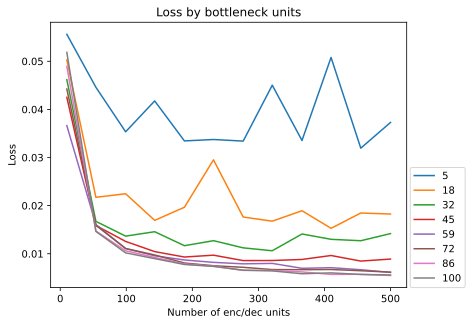

In [8]:
plt.plot(N_encdec_units,exp_results)
plt.legend(N_bottle_units,loc=(1.01,0))
plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')
plt.show()